In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
from matplotlib import colors

from matplotlib import cm, rc
from matplotlib import animation

## Main simulation code

In [0]:
class Lane(object):
  '''
  Simulates the in-lane behavior
  
  Attributes:
   self.road_length- the number of cells
   self.init_traffic_p - density probability at init
   self.vmax - possible maximum velocity
   self.slow_down_p - Random slow down probability self.speed car speed on the road
   self.any_cars - in case there are not any cars, generate a car at the first 
     space of the lane
   self.total_passing_cars - Counts the cars passing the origin
   self.flow- Number of cars passing in the periodic boundary
   self.gap- Number of empty cells between a car and the car in front of it
   self.distance- number of steps a car needs to take to reach the spot of the
     car in front of it (=gap+1)
   
  '''
  
  def __init__(self, init_traffic_p=.3, init_road_length=100, 
               max_velocty=5, slow_down_p=.1):
    
    self.road_length = init_road_length 
    self.init_traffic_p = init_traffic_p 
    self.vmax = max_velocty 
    self.slow_down_p = slow_down_p 
    self.speed = np.random.choice([-1,0],self.road_length, 
                                  p=[1-self.init_traffic_p,self.init_traffic_p])
    self.any_cars = np.any(self.speed!=-1)
    self.total_passing_cars=0.0
    self.flow=0
    
    if not self.any_cars:
      self.speed[0]=0
      
    self.gap=np.full_like(self.speed,0)
    self.distance = np.full_like(self.speed,0)
    
    self.update_distance()

    
  def update_distance(self):
    '''
    The distance reflects the number of steps a car needs to take to reach 
    the car in front of it.
    
    Method: 
    finding all indexes of cars, calculating the diff between them
    assigning this differences to the correct indexes
    ''' 

    tmp_state = np.full_like(self.distance, 0)
    car_indexes=np.where(self.speed!=-1)[0]
    car_indexes=np.append(car_indexes, car_indexes[0])
    indexes_distance=np.ediff1d(car_indexes)%self.road_length

    # if there's only one car
    if len(indexes_distance)==1 and indexes_distance==[0]:
      indexes_distance=[self.road_length]

    car_indexes=car_indexes[:-1]

    #assign back to distance
    tmp_state[car_indexes]=indexes_distance
    self.distance=tmp_state
    self.gap=self.distance-[1]

  def update_flow(self):
    '''
    The flow is the ratio of the number of cars to spaces in a given time period
    
    Method: 
    counting all cars that crossed the periodic boundary at a step
    '''
    last_car_index=np.where(self.speed!=-1)[0][-1]
    car_pass = self.speed[last_car_index]+last_car_index >= self.road_length

    if car_pass:
      self.total_passing_cars+=1.0

    
  def deterministic_slow_down(self):
    '''
    Deterministic slow down: the speed limit by the distance of the car
    in front of it 
    '''
    ## slow down, take the min between the distance-1 and current speed
    max_possible_speed = self.distance-1
    self.speed = np.minimum(max_possible_speed, self.speed)
  
  def accelerate(self):
    '''
    Acceleration: a car will accelerate to v+1 if there is enough space 
    '''
    ## accelerate to speed+1 or 5 IF there is space
    has_space = self.distance -1 > self.speed
    not_empty = self.speed > -1 
    
    self.speed = np.minimum(self.speed+(has_space), 5) 
    
  def random_slow_down(self):
    '''
    Random slow down: cars slow down randomly given a probability    
    '''
    ## random slow down based on slow down probability
    should_decrease = np.random.random(self.road_length) < self.slow_down_p
    can_decrease = self.speed > 0
    
    self.speed = self.speed-(should_decrease*can_decrease)
    
    
  def update_speed(self):
    '''
    Update all speed aspects
    '''   
    self.deterministic_slow_down()
    self.accelerate()
    self.random_slow_down()
    
  
  def update_position(self):
    '''
    Update position: progresses all cars to their updated speeds.
    
    Method:
    creates temp array of -1s
    finds cars indexes and their respective next state position 
    (using their respective velocities)
    
    assigns the cars' velocity value to their new position using the temp array
    assigns the temp array to the actual speed array
    '''
    new_state = np.full_like(self.speed, -1)
    car_indexes = np.where(self.speed != -1)[0]
    new_positions = (self.speed[car_indexes]+car_indexes)%self.road_length
    new_state[new_positions] = self.speed[car_indexes]
    self.speed = new_state
     
    
  def update(self):
    '''
    Progress the simulation by one step
    
    Method:
    using all update functions
    '''
    self.update_speed() 
    self.update_flow()
    self.update_position()
    self.update_distance()
    
    
 
      
    

In [0]:
class Road(object):
  '''
  Simulates the road behavior. Manages all lanes within the road
  
  Attributes:
   
  ## These must be the same for all lanes
   self.road_length- the number of cells 
   self.vmax - possible maximum velocity 
   self.slow_down_p - random slow down probability
   self.change_lane_p - The probability of lane change if conditions allow
   self.lane_densities- an array with the density of each lane
   self.lanes - an array of lanes
   self.lookback_other- the distance that a car looks back before moving
   self.norm_flow- number of cars passing in the periodic boundary per lane
   self.total_flow- number of cars passing in the periodic boundary total
   self.sim_history- Collects all simulation data
   self.swaps- number of cars which swapped lanes
  '''
  def __init__(self, init_traffic_p=[.3,.3], init_road_length=100, 
               max_velocty=5, slow_down_p=.1, look_back_other=5, 
               p_change=1):
    
    self.road_length = init_road_length 
    self.vmax = max_velocty 
    self.slow_down_p = slow_down_p 
    self.change_lane_p = p_change
    
    self.lane_densities = init_traffic_p
    self.lanes = [Lane(p, self.road_length, self.vmax, self.slow_down_p) 
                  for p in self.lane_densities]
    
    self.lookback_other = look_back_other
    self.norm_flow=0
    self.total_flow=0
    self.sim_history = []
    self.swaps = 0
    
  def calc_cross_lane_gap(self, origin_lane, dest_lane):
    '''
    The distance reflects the number of open spaces between two cars
    
    Method: 
    finding all indexes of cars, calculating the diff between them
    assigning this differences to the correct indexes
    
    This function of code was co-developed with Josh Broomeberg
    ''' 
    
    # find indexes of cars in both lanes
    origin_car_indexes=np.where(origin_lane.speed!=-1)[0]
    dest_car_indexes=np.where(dest_lane.speed!=-1)[0]

    #sort by indexes
    dest_lane_length = len(dest_car_indexes)
    lane_sort = np.arange(dest_lane_length)
    
    
    # finds the hypothetical positions of the cars from the original lane
    # in the destination lane. The 'right' side checks cars behind and the 
    # 'left' side looks at cars at the front
    
    back_positions = np.searchsorted(dest_car_indexes, 
                                             origin_car_indexes, 
                                             side="right", sorter=lane_sort)
    
    front_positions = np.searchsorted(dest_car_indexes, 
                                              origin_car_indexes, 
                                              side="left", sorter=lane_sort)
    if dest_lane_length!=0:
      back_cars_positions = dest_car_indexes[back_positions-1] 
      front_cars_poisitions=dest_car_indexes[front_positions%dest_lane_length]
    
      # using the hypothetical positions, I calculate the gaps, each value
      # corresponds to a car in the origin lane  
      back_gaps=((origin_car_indexes-back_cars_positions)
                 %self.road_length)-1
      front_gaps=((front_cars_poisitions-origin_car_indexes)
                  %self.road_length)-1
    else:
      back_gaps = np.array([self.road_length]*(len(origin_car_indexes)))
      front_gaps = np.array([self.road_length]*(len(origin_car_indexes)))
      
    return {'front':front_gaps,'back':back_gaps}

  
  def swap_lane(self, copy_lanes, to_left, original_rules=True, 
                symmetric=True):
    '''
    Swap lanes given the following rules:
    1. want to swap?  current_lane_distance-1 < speed 
    2. could swap? other_lane_front_gap>l_o and other_lane_back_gap>l_o_back
    
    if both true, swap.
    
    Method:
    calculating the gaps in both the current lane and other lane and comparing 
    them to the given thresholds, the function returns a binary array for each 
    car in the origin lane, True indicate swapping, and False indicates staying.
    '''
    # calculate gaps between cars
    lane, cross_lane = copy_lanes
    
    gaps = self.calc_cross_lane_gap(lane, cross_lane)
    cars_speed_indexes = np.where(lane.speed!=-1)[0]
    
    # calculate swapping conditions
    if not symmetric and to_left:
    #if moving from left to right, assign True for all
      want_to_swap = np.array([True]*(len(cars_speed_indexes)))
    else:
      want_to_swap = lane.distance[cars_speed_indexes]-1 \
                <= lane.speed[cars_speed_indexes]
           
    
    if original_rules:
      # only moves if does not need to slow down
      could_swap_front = gaps['front'] > lane.speed[cars_speed_indexes]
    else:
      # moves if can advance its potision compared to its current lane
      could_swap_front = gaps['front'] > lane.distance[cars_speed_indexes]-1
    
    #calculate conditions
    could_swap_back = gaps['back'] > self.lookback_other
    random_swap = np.random.random(len(cars_speed_indexes))<self.change_lane_p
    
    swapping = want_to_swap*could_swap_front*could_swap_back*random_swap


    return swapping
 
  def swap_lanes(self, original_rules=True, symmetric=True):
    ''' 
    This function manages the double swap. It uses the "swap_lane" function 
    on both lanes to check for cars swapping lanes in both directions. 
    Updates the positions of both lanes. 
    
    This function also calculates the total swapping cars.
    
    Method:
    using the binary arrays from "swap_lane," it adds the swapping cars' speed 
    in the correct position in the other lane and inserts -1 in the origin lane. 
    This uses a deep copy to simulate a parallel update.
    
    The total swapping cars are calculated by counting the difference in the 
    amount of cars in the first lane 

    '''
    N = len(self.lanes)
    #number of cars in 1st before swapping
    positions = []
    positions.append(np.count_nonzero(self.lanes[0].speed+1))

    # copy lanes to ensure the order of swap does not impact the results
    output_lanes = copy.deepcopy(self.lanes)

    # fins car indexes in all lanes
    car_indexes = []
    for lane_index in range(N):
      car_indexes.append(np.where(output_lanes[lane_index].speed!=-1)[0])
    swaps_lanes_indexes = [1,-1]
    
    # move right. thus indexes [i,i+1%N]
    for lane_index in range(N):
      
    # both in left and right movements. This ensures consideration of left
    # movement.
      
      if N==2 and lane_index==1: 
        moving_left = True
      else:
        moving_left = False
      
      if len(car_indexes[lane_index])>0: 
        swap_rule_left = self.swap_lane([output_lanes[lane_index],
                                    output_lanes[(lane_index+1)%N]], 
                                   moving_left, original_rules, symmetric)
        # removing
        self.lanes[lane_index].speed[car_indexes[lane_index]]=\
          self.lanes[lane_index].speed[car_indexes[lane_index]]-\
          (output_lanes[lane_index].speed[car_indexes[lane_index]]+1)*\
          swap_rule_left
        
        # adding
        self.lanes[(lane_index+1)%N].speed[car_indexes[lane_index]]=\
          self.lanes[(lane_index+1)%N].speed[car_indexes[lane_index]]+\
          (output_lanes[lane_index].speed[car_indexes[lane_index]]+1)*\
          swap_rule_left
        
        positions.append(np.count_nonzero(self.lanes[lane_index].speed+1)) 
    
    if N>2:
    # two lanes does not require two ways change since 
    # it will create a duplication
    
      # move left. thus indexes [i,i-1%N]
      for lane_index in range(N):
        if len(car_indexes[lane_index])>0: 
         
          swap_rule_right = self.swap_lane([output_lanes[lane_index],
                                      output_lanes[(lane_index-1)%N]], 
                                     True, original_rules, symmetric)
        # removing
        self.lanes[lane_index].speed[car_indexes[lane_index]]=\
          self.lanes[lane_index].speed[car_indexes[lane_index]]-\
          (output_lanes[lane_index].speed[car_indexes[lane_index]]+1)*\
          swap_rule_right

        # adding
        self.lanes[(lane_index-1)%N].speed[car_indexes[lane_index]]=\
          self.lanes[(lane_index-1)%N].speed[car_indexes[lane_index]]+\
          (output_lanes[lane_index].speed[car_indexes[lane_index]]+1)*\
          swap_rule_right

        positions.append(np.count_nonzero(self.lanes[lane_index].speed+1)) 


  
    
   # number of cars per lane after both  swapping
    positions.append(np.count_nonzero(self.lanes[0].speed+1))
      
    # calc swaps:
    self.swaps += np.sum(np.diff(positions))
  
  def simple_display(self, lanes):
    # display using text
    for lane in lanes:
      print(''.join('.' if x == -1 else str(x) for x in lane[:70]))
    print()
       
    
       
  def plot(self):
    if len(self.lanes)==2:
      ## two lanes plot
      lane_1 = [self.sim_history[step][0] 
                for step in np.arange(len(self.sim_history))]
      lane_2 = [self.sim_history[step][1] 
                for step in np.arange(len(self.sim_history))]

      fig = plt.figure()
      ax1 = fig.add_subplot(121)
      ax2 = fig.add_subplot(122)

      ax1.axis('off')
      ax2.axis('off')

      ax1.title.set_text('First Lane')
      ax2.title.set_text('Second Lane')

      ax1.imshow(lane_1, vmin=-1, vmax=0, 
                       cmap=cm.get_cmap('binary', 2))
      ax2.imshow(lane_2, vmin=-1, vmax=0, 
                       cmap=cm.get_cmap('binary', 2))


      plt.show()
    
    elif len(self.lanes)==1:
      ## one lane plot
      lane_1 = [self.sim_history[step][0] 
                for step in np.arange(len(self.sim_history))]
      plt.axis('off')
      plt.imshow(lane_1, vmin=-1, vmax=0, 
                       cmap=cm.get_cmap('binary', 2))
      plt.show()
      
    
  def run_sim(self, N, display=True, original_rules=True, symmetric = True):
    '''
    Runs the simulation for the whole road N times using the swap and update
    rules
    
    display dictates whether to display the simulation
    original_rules dictates the set of rule to use
      1. original rules- swap only if can make the full step (given the speed)
      2. not original- swap whenever the distance in the other lane is better
      
    Symmetric- swap rules apply equally on both lanes. If False, cars will try
      to go right regardless of the situation in the left lane.
    
    '''
    
    for i in range(N):
      # store and display
      self.sim_history.append([l.speed for l in self.lanes])
      if display :
        self.simple_display([lane.speed for lane in self.lanes]) 
        
      # swap if multi lane  
      if len(self.lane_densities)>=2: 
        self.swap_lanes(original_rules, symmetric)
        
      #update all lanes
      for lane in self.lanes:
        # if there are cars in the lane
        if len(np.where(lane.speed!=-1)[0])>0:
          lane.update_distance() # to include new cars
          lane.update()

    self.norm_flow=np.mean([lane.total_passing_cars/N for lane 
                      in self.lanes])
    
    self.total_flow=np.sum([lane.total_passing_cars/N for lane 
                      in self.lanes])
    

### PLOTS

One lane


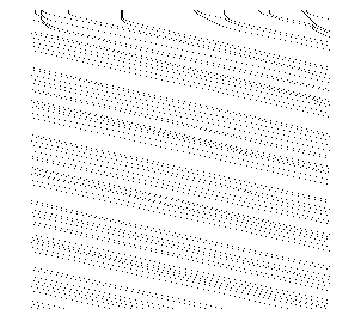

In [5]:
##Lane behavior:
print ('One lane')
config = [[.05], 250, 5, 0.5, 5, 1]

r=Road(*config)

r.run_sim(250, display=False, original_rules=True, symmetric = True)
r.plot()



One lane


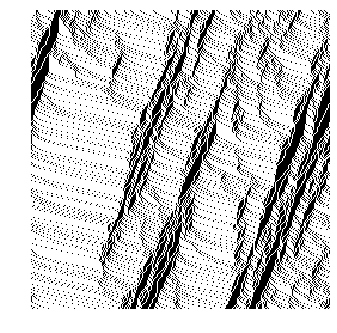

In [6]:
##Lane behavior:
print ('One lane')
config = [[.3], 250, 5, 0.5, 5, 1]

r=Road(*config)

r.run_sim(250, display=False, original_rules=True, symmetric = True)
r.plot()



Symmetric lanes


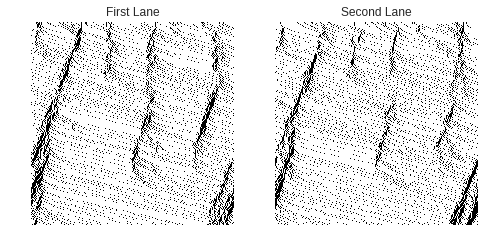

In [7]:
##Lane behavior:
print ('Symmetric lanes')
config = [[.15,.15], 250, 5, 0.5, 5, 1]

r=Road(*config)

r.run_sim(250, display=False, original_rules=True, symmetric = True)
r.plot()



Symmetric lanes


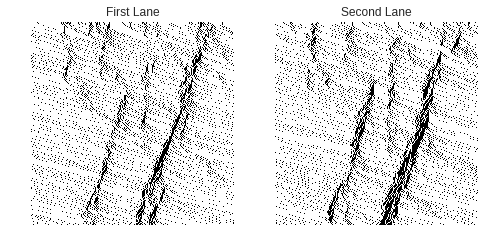

In [8]:
##Lane behavior:
print ('Symmetric lanes')
config = [[.15,.15], 250, 5, 0.5, 5, .7]

r=Road(*config)

r.run_sim(250, display=False, original_rules=True, symmetric = True)
r.plot()



Asymmetric lanes


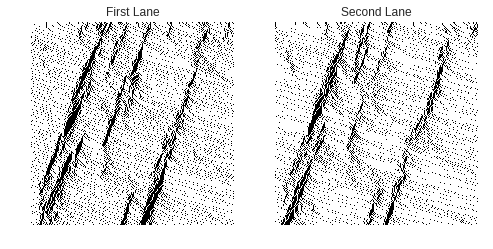

In [9]:
##Lane behavior:
print ('Asymmetric lanes')
config = [[.15,.15], 250, 5, 0.5, 5, 1]

r=Road(*config)

r.run_sim(250, display=False, original_rules=True, symmetric = False)
r.plot()



In [0]:
## Generating data for plots
## comparing one and two lanes

N=50
D=50

S=100
densities = np.linspace(.01,.9,D)

#collects reaults 
results_one_lane = np.empty((D,N)) 
results_two_lanes_symm = np.empty((D,N))
results_two_lanes_asymm = np.empty((D,N))
results_two_lanes_symm_bad = np.empty((D,N))

car_swapped_symm = np.empty((D,N))
car_swapped_asymm = np.empty((D,N))
car_swapped_symm_bad = np.empty((D,N))

for d, density in enumerate(densities):
  for n in range(N):
    conf_one_lane = [[density], 100, 5, 0.5, 5, 1]
    conf_two_lanes = [[density, density], 100, 5, 0.5, 5, 1]
    conf_two_lanes_bad = [[density, density], 100, 7, 0.8, 3, .7]
    
    #one lane
    sim1 = Road(*conf_one_lane)
    sim1.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    #two lanes sym
    sim2 = Road(*conf_two_lanes)
    sim2.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    #two lanes asym
    sim3 = Road(*conf_two_lanes)
    sim3.run_sim(S, display=False, original_rules=True, symmetric = False)
    
    #two lanes sym bad drivers behavior sym
    sim4 = Road(*conf_two_lanes_bad)
    sim4.run_sim(S, display=False, original_rules=False, symmetric = True)
    
    results_one_lane[d][n] = sim1.norm_flow
    results_two_lanes_symm[d][n] = sim2.norm_flow
    results_two_lanes_asymm[d][n] = sim3.norm_flow
    results_two_lanes_symm_bad[d][n] = sim4.norm_flow
    
    car_swapped_symm[d][n] = sim2.swaps
    car_swapped_asymm[d][n] = sim3.swaps
    car_swapped_symm_bad[d][n] = sim4.swaps

In [0]:
## Generating data for plots
## comparing multiple lanes

N=50
D=50

S=100
densities = np.linspace(.01,.9,D)

#collects reaults 
results_1 = np.empty((D,N))
results_2 = np.empty((D,N))
results_3 = np.empty((D,N)) 
results_4 = np.empty((D,N))


for d, density in enumerate(densities):
  for n in range(N):
    conf_1 = [[density], 100, 5, 0.5, 5, 1]
    conf_2 = [[density,density], 100, 5, 0.5, 5, 1]
    conf_3 = [[density,density,density], 100, 7, 0.5, 5, 1]
    conf_4 = [[density,density,density,density], 100, 7, 0.5, 5, 1]

    
    #one lane
    sim1 = Road(*conf_1)
    sim1.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    #two lanes 
    sim2 = Road(*conf_2)
    sim2.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    #three lanes 
    sim3 = Road(*conf_3)
    sim3.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    #four lanes 
    sim4 = Road(*conf_4)
    sim4.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    
    results_1[d][n] = sim1.norm_flow
    results_2[d][n] = sim2.norm_flow
    results_3[d][n] = sim3.norm_flow
    results_4[d][n] = sim4.norm_flow


In [0]:
## Comparing system sizes

N=50
D=50

S=100
densities = np.linspace(.01,.9,D)

#collects reaults 
results_one_lane50 = np.empty((D,N))
results_one_lane500 = np.empty((D,N)) 
results_one_lane200 = np.empty((D,N))



for d, density in enumerate(densities):
  for n in range(N):
    conf_50 = [[density], 50, 5, 0.5, 5, 1]
    conf_500 = [[density], 500, 5, 0.5, 5, 1]
    conf_200 = [[density], 200, 5, 0.5, 5, 1]
    
    #one lane
    sim1 = Road(*conf_50)
    sim1.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim2 = Road(*conf_500)
    sim2.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim3 = Road(*conf_200)
    sim3.run_sim(S, display=False, original_rules=True, symmetric = True)

    
    results_one_lane50[d][n] = sim1.norm_flow
    results_one_lane500[d][n] = sim2.norm_flow
    results_one_lane200[d][n] = sim3.norm_flow
    

In [0]:
## Comparing slow down probabilities

N=50
D=50

S=100
densities = np.linspace(.01,.9,D)

#collects results 
results_one_lane1 = np.empty((D,N))
results_one_lane3 = np.empty((D,N))
results_one_lane5 = np.empty((D,N)) 
results_one_lane7 = np.empty((D,N))
results_one_lane9 = np.empty((D,N))


for d, density in enumerate(densities):
  for n in range(N):
    conf_1 = [[density], 100, 5, 0.1, 5, 1]
    conf_3 = [[density], 100, 5, 0.3, 5, 1]
    conf_5 = [[density], 100, 5, 0.5, 5, 1]
    conf_7 = [[density], 100, 5, 0.7, 5, 1]
    conf_9 = [[density], 100, 5, 0.9, 5, 1]
    
    #one lane
    sim1 = Road(*conf_1)
    sim1.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim2 = Road(*conf_3)
    sim2.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim3 = Road(*conf_5)
    sim3.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim4 = Road(*conf_7)
    sim4.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim5 = Road(*conf_9)
    sim5.run_sim(S, display=False, original_rules=True, symmetric = True)

    
    results_one_lane1[d][n] = sim1.norm_flow
    results_one_lane3[d][n] = sim2.norm_flow
    results_one_lane5[d][n] = sim3.norm_flow
    results_one_lane7[d][n] = sim4.norm_flow
    results_one_lane9[d][n] = sim5.norm_flow
    

In [0]:
## Comparing lane changing prob

N=50
D=50

S=100
densities = np.linspace(.01,.9,D)

#collects results 
results_2_lane1 = np.empty((D,N))
results_2_lane3 = np.empty((D,N))
results_2_lane5 = np.empty((D,N)) 
results_2_lane7 = np.empty((D,N))
results_2_lane9 = np.empty((D,N))


for d, density in enumerate(densities):
  for n in range(N):
    conf_1 = [[density,density], 100, 5, 0.5, 5, 0.1]
    conf_3 = [[density,density], 100, 5, 0.5, 5, 0.3]
    conf_5 = [[density,density], 100, 5, 0.5, 5, 0.5]
    conf_7 = [[density,density], 100, 5, 0.5, 5, 0.7]
    conf_9 = [[density,density], 100, 5, 0.5, 5, 0.9]
    
    #two lanes
    sim1 = Road(*conf_1)
    sim1.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim2 = Road(*conf_3)
    sim2.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim3 = Road(*conf_5)
    sim3.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim4 = Road(*conf_7)
    sim4.run_sim(S, display=False, original_rules=True, symmetric = True)
    
    sim5 = Road(*conf_9)
    sim5.run_sim(S, display=False, original_rules=True, symmetric = True)

    
    results_2_lane1[d][n] = sim1.norm_flow
    results_2_lane3[d][n] = sim2.norm_flow
    results_2_lane5[d][n] = sim3.norm_flow
    results_2_lane7[d][n] = sim4.norm_flow
    results_2_lane9[d][n] = sim5.norm_flow
    

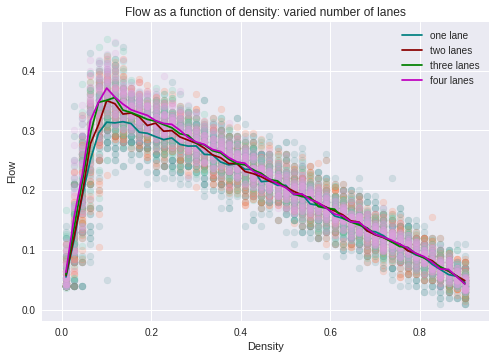

[0.3144, 0.34970000000000007, 0.3549333333333333, 0.37065]


In [85]:
maximums = [np.max(np.mean(r,axis=1)) for r in [results_1,
                      results_2,results_3,
                           results_4]]

for d,r1,r2,r3,r4 in zip(densities,results_1,
                      results_2,results_3,
                           results_4):
  
  plt.scatter([d]*N,r1, c='cadetblue', alpha=.2)
  plt.scatter([d]*N,r2, c='coral', alpha=.2)
  plt.scatter([d]*N,r3, c='mediumaquamarine', alpha=.2)
  plt.scatter([d]*N,r4, c='plum', alpha=.2)

plt.plot(densities,np.mean(results_1,axis=1), 
         label='one lane', c='teal')
plt.plot(densities,np.mean(results_2,axis=1), 
         label='two lanes', c='darkred')
plt.plot(densities,np.mean(results_3,axis=1), 
         label='three lanes', c='g')
plt.plot(densities,np.mean(results_4,axis=1), 
         label='four lanes', c='m')


plt.title('Flow as a function of density: varied number of lanes')
plt.xlabel('Density')
plt.legend()
plt.ylabel('Flow')

plt.show()
print (maximums)

In [107]:
improvement =[]
for i in range(len(maximums)-1): 
  x0= maximums[0]
  x= maximums[i]
  y = maximums[i+1]
  print('{} lanes to {} lane(s), {}% improvement'.format(i+2, i+1, np.round((y-x)/x*100,2)))
  
  improvement.append( np.round((y-x0)/x0*100,2))


2 lanes to 1 lane(s), 11.23% improvement
3 lanes to 2 lane(s), 1.5% improvement
4 lanes to 3 lane(s), 4.43% improvement


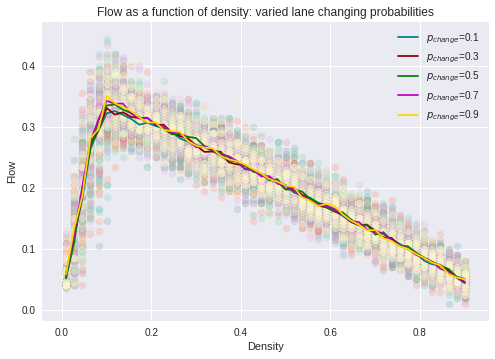

In [69]:
#for d,r1,r2,r3,r4,r5 in zip(densities,results_2_lane1,
                      results_2_lane3,results_2_lane5,
                           results_2_lane7,results_2_lane9):
  
  plt.scatter([d]*N,r1, c='cadetblue', alpha=.2)
  plt.scatter([d]*N,r2, c='coral', alpha=.2)
  plt.scatter([d]*N,r3, c='mediumaquamarine', alpha=.2)
  plt.scatter([d]*N,r4, c='plum', alpha=.2)
  plt.scatter([d]*N,r5, c='lemonchiffon', alpha=.2)

plt.plot(densities,np.mean(results_2_lane1,axis=1), 
         label='$p_{change}$=0.1', c='teal')
plt.plot(densities,np.mean(results_2_lane3,axis=1), 
         label='$p_{change}$=0.3', c='darkred')
plt.plot(densities,np.mean(results_2_lane5,axis=1), 
         label='$p_{change}$=0.5', c='g')
plt.plot(densities,np.mean(results_2_lane7,axis=1), 
         label='$p_{change}$=0.7', c='m')
plt.plot(densities,np.mean(results_2_lane9,axis=1), 
         label='$p_{change}$=0.9', c='gold')

plt.title('Flow as a function of density: varied lane changing probabilities')
plt.xlabel('Density')
plt.legend()
plt.ylabel('Flow')

plt.show()


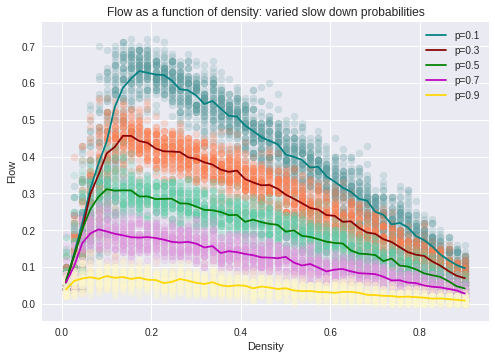

In [36]:
for d,r1,r2,r3,r4,r5 in zip(densities,results_one_lane1,
                      results_one_lane3,results_one_lane5,
                           results_one_lane7,results_one_lane9):
  
  plt.scatter([d]*N,r1, c='cadetblue', alpha=.2)
  plt.scatter([d]*N,r2, c='coral', alpha=.2)
  plt.scatter([d]*N,r3, c='mediumaquamarine', alpha=.2)
  plt.scatter([d]*N,r4, c='plum', alpha=.2)
  plt.scatter([d]*N,r5, c='lemonchiffon', alpha=.2)

plt.plot(densities,np.mean(results_one_lane1,axis=1), 
         label='p=0.1'.format(max_one_lane), c='teal')
plt.plot(densities,np.mean(results_one_lane3,axis=1), 
         label='p=0.3'.format(max_one_lane), c='darkred')
plt.plot(densities,np.mean(results_one_lane5,axis=1), 
         label='p=0.5'.format(max_one_lane), c='g')
plt.plot(densities,np.mean(results_one_lane7,axis=1), 
         label='p=0.7'.format(max_one_lane), c='m')
plt.plot(densities,np.mean(results_one_lane9,axis=1), 
         label='p=0.9'.format(max_one_lane), c='gold')

plt.title('Flow as a function of density: varied slow down probabilities')
plt.xlabel('Density')
plt.legend()
plt.ylabel('Flow')

plt.show()


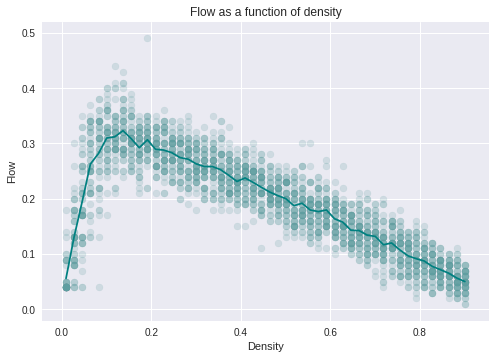

In [23]:
for d,r1 in zip(densities,results_one_lane):
  
  plt.scatter([d]*N,r1, c='cadetblue', alpha=.2)

plt.plot(densities,np.mean(results_one_lane,axis=1), 
         label='One lane, max flow={}'.format(max_one_lane), c='teal')

plt.title('Flow as a function of density')
plt.xlabel('Density')
plt.ylabel('Flow')

plt.show()


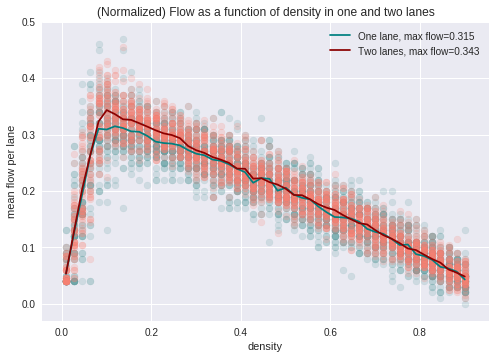

Percentage growth: 8.16%


In [37]:
max_one_lane = np.round(np.max(np.mean(results_one_lane,axis=1)),3)
max_two_lanes = np.round(np.max(np.mean(results_two_lanes_symm,axis=1)),3)

for d,r1,r2 in zip(densities,results_one_lane,results_two_lanes_symm):
  
  plt.scatter([d]*N,r1, c='cadetblue', alpha=.2)
  plt.scatter([d]*N,r2, c='salmon', alpha=.2)

plt.plot(densities,np.mean(results_one_lane,axis=1), 
         label='One lane, max flow={}'.format(max_one_lane), c='teal')
plt.plot(densities,np.mean(results_two_lanes_symm,axis=1), 
         label='Two lanes, max flow={}'.format(max_two_lanes), c='darkred')

plt.title('(Normalized) Flow as a function of density in one and two lanes')
plt.xlabel('density')
plt.ylabel('mean flow per lane')

plt.legend()
plt.show()

print('Percentage growth: {}%'.format(np.round( (max_two_lanes-max_one_lane)/max_two_lanes*100,2) ))

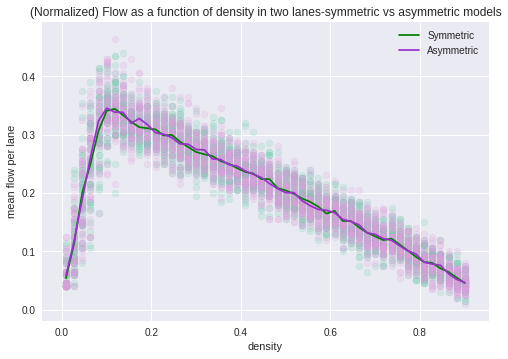

In [40]:
for d,r1,r2 in zip(densities,results_two_lanes_symm,results_two_lanes_asymm):
  
  plt.scatter([d]*N,r1, c='mediumaquamarine', alpha=.2)
  plt.scatter([d]*N,r2, c='plum', alpha=.2)

plt.plot(densities,np.mean(results_two_lanes_symm,axis=1), 
         label='Symmetric', c='green')
plt.plot(densities,np.mean(results_two_lanes_asymm,axis=1), 
         label='Asymmetric', c='darkorchid')

plt.title('(Normalized) Flow as a function of density in two lanes-symmetric vs asymmetric models')
plt.xlabel('density')
plt.ylabel('mean flow per lane')

plt.legend()
plt.show()

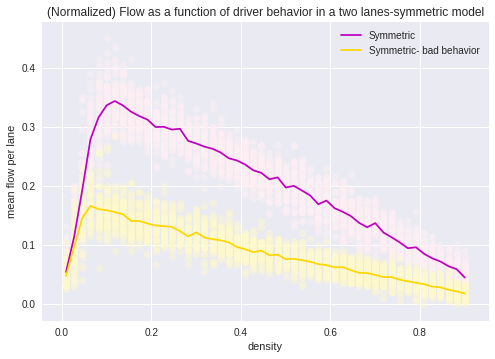

Percentage growth: 107.23%


In [70]:
for d,r1,r2 in zip(densities,results_two_lanes_symm,results_two_lanes_symm_bad):
  
  plt.scatter([d]*N,r1, c='lavenderblush', alpha=.4)
  plt.scatter([d]*N,r2, c='lemonchiffon', alpha=.4)

plt.plot(densities,np.mean(results_two_lanes_symm,axis=1), 
         label='Symmetric', c='m')
plt.plot(densities,np.mean(results_two_lanes_symm_bad,axis=1), 
         label='Symmetric- bad behavior', c='gold')

plt.title('(Normalized) Flow as a function of driver behavior in a two lanes-symmetric model')
plt.xlabel('density')
plt.ylabel('mean flow per lane')

plt.legend()
plt.show()

max_nor = np.round(np.max(np.mean(results_two_lanes_symm,axis=1)),3)
max_bad = np.round(np.max(np.mean(results_two_lanes_symm_bad,axis=1)),3)

print('Percentage growth: {}%'.format(np.round( (max_nor-max_bad)/max_bad*100,2) ))

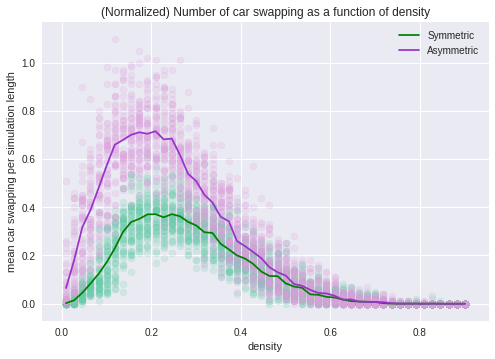

In [61]:
for d,c_symm, c_asymm, c_symm_bad in zip(densities,car_swapped_symm, 
                                         car_swapped_asymm, 
                                         car_swapped_symm_bad):
  plt.scatter([d]*N,c_symm/S, c='mediumaquamarine', alpha=.2)
  plt.scatter([d]*N,c_asymm/S, c='plum', alpha=.2)

plt.plot(densities,np.mean(car_swapped_symm,axis=1)/S, 
         label='Symmetric', c='green')
plt.plot(densities,np.mean(car_swapped_asymm,axis=1)/S, 
         label='Asymmetric', c='darkorchid')


plt.title('(Normalized) Number of car swapping as a function of density')
plt.xlabel('density')
plt.ylabel('mean car swapping per simulation length')

plt.legend()
plt.show()

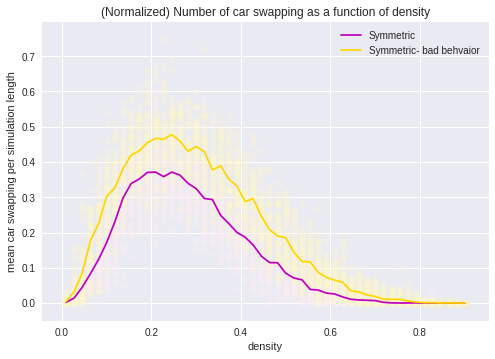

In [63]:
for d,c_symm, c_symm_bad in zip(densities,car_swapped_symm, 
                                         car_swapped_symm_bad):
  plt.scatter([d]*N,c_symm/S, c='lavenderblush', alpha=.2)
  plt.scatter([d]*N,c_symm_bad/S, c='lemonchiffon', alpha=.2)

plt.plot(densities,np.mean(car_swapped_symm,axis=1)/S, 
         label='Symmetric', c='m')

plt.plot(densities,np.mean(car_swapped_symm_bad,axis=1)/S, 
         label='Symmetric- bad behvaior', c='gold')

plt.title('(Normalized) Number of car swapping as a function of density')
plt.xlabel('density')
plt.ylabel('mean car swapping per simulation length')

plt.legend()
plt.show()

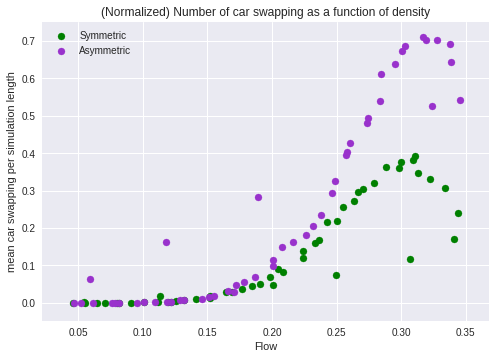

In [56]:


plt.scatter(np.mean(results_two_lanes_symm,axis=1),np.mean(car_swapped_symm,axis=1)/S, 
         label='Symmetric', c='green')
plt.scatter(np.mean(results_two_lanes_asymm,axis=1),np.mean(car_swapped_asymm,axis=1)/S, 
         label='Asymmetric', c='darkorchid')
# plt.plot(densities,np.mean(car_swapped_symm_bad,axis=1)/S, 
#          label='Symmetric- bad behvaior', c='dodgerblue')

plt.title('(Normalized) Number of car swapping as a function of density')
plt.xlabel('Flow')
plt.ylabel('mean car swapping per simulation length')

plt.legend()
plt.show()